In [2]:
"""
TENSORFLOW

LIBRERIA MATEMATICA OPEN-SOURCE DI GOOGLE
PER SEMPLIFICARE L'UTILIZZO DI TECNICHE DI MACHINE LEARNING
DA USARE NELLE RETI NEURALI E IN TUTTE LE SUE VARIANTI
CHE SONO GIA' IMPLEMENTATE IN QUESTA LIBRERIA

INOLTRE PERMETTE DI COSTRUIRE MODELLI DI RETI NEURALI E TUTTE LE SUE VARIANTI
CHE UTILIZZANO QUESTI ALGORITMI DI MACHINE LEARNING COME BACK PROPAGATION
UTILI A IMPARARE DURANTE IL TRAINING CERCANDO DI MINIMIZZARE IL GRADIENTE
DELLA FUNZIONE A PIU' VARIABILI DEFINITA DALLA RETE NEURALE

I MODELLI DI RETI NEURALI SONO DEI GRAFI DOVE:
- NODI
  NEURONI CHE RAPPRESENTANO UN'OPERAZIONE MATEMATICA CHE NORMALIZZA L'OUTPUT RICEVUTO
- ARCHI
  SINAPSI CHE RAPPRESENTANO I TENSORI, CIOE' UN ARRAY MULTIDIMENSIONALE

E' UNA LIBRERIA PYTHON, LINGUAGGIO CON UN'ASTRAZIONE AD ALTO LIVELLO SIMILE ALL'INGLESE,
CHE PERO' FUNGE SOLO DA INTERPRETE TRA L'UTENTE
E IL FRAMEWORK CONTENENTE LE OPERAZIONI MATEMATICHE SCRITTO IN C++

------------------------------------------------

KERAS API

HIGH-LEVEL API FORNITA DA TENSORFLOW 2.0
CHE PERMETTE DI COSTRUIRE UN MODELLO DI UNA RETE NEURALE
IN MODO PIU' SEMPLICE RISPETTO ALLE PRECEDENTI

ESSA SUPPORTA MOLTI TIPI DI MOTORI DI CALCOLO PER IL BACK-END DELLE RETI NEURALI

RISPETTO A TENSORFLOW CORE API E' PIU' AD ALTO LIVELLO
ED ACCESSIBILE ANCHE A CHI E' MENO ESPERTO
ANCHE SE PROGRAMMARE A BASSO LIVELLO CONSENTE DI:
- GESTIRE PIU' IN DETTAGLIO LA CURVA DI APPRENDIMENTO
- MIGLIORE DEBUGGING
MA SI PUO' FARE ANCHE UN MIX TRA I DUE

KERAS E':
- USER-FRIENDLY
- SEGUE LE MIGLIORI PRATICHE DI MACHINE LEARNING PER RIDURRE IL CARICO COGNITIVO
- MODULARE

MODULI PRE-PROGRAMMATI (STANDALONE):
- NEURAL LAYERS
- COST FUNCTIONS
- OPTIMIZERS
- INITIALIZATION SCHEMES
- ACTIVATION FUNCTIONS
- REGULARIZATION SCHEMES

SCRITTA IN PYTHON

--------------------------------------

KERAS BACK-END

KERAS NON SI OCCUPA DI FARE OPERAZIONI A BASSO LIVELLO
COME DOT PRODUCT TRA TENSORI E CONVOLUZIONI
DELEGA QUESTE OPERAZIONI AD UN BACK-END ENGINE
SUPPORTA MOLTI TIPI DI BACKEND MA QUELLO PRINCIPALE DI CUI E' API E' TENSORFLOW

----------------------------------------

KERAS MODEL

STRUTTURA DATI PRINCIPALE DI KERAS, ESISTONO 2 TIPI:
- SEQUENTIAL MODEL
- MODEL CLASS

SEQUENTIAL MODEL

PREVEDE UNA STACK DI LAYERS LINEARE
DOVE LE ACTIVATION, LOSS FUNCTIONS POSSONO ESSERE CHIAMATE IN FORMATO STRINGA
COMPOSTO DA:
- model.fit()
  FA L'ALLENAMENTO IN GRUPPI (FITTING)
- model.evaluate()
  CALCOLA LE METRICHE E LE PERDITE PER IL MODELLO GIA' ALLENATO
- model.predict()
  PRENDE UN INPUT, LO SOTTOPONE AL MODELLO ALLENATO, GENERA UN OUTPUT CON UNA ETICHETTA

MODEL CLASS - KERAS FUNCTIONAL API

UTILE PER CREARE MODELLI COMPLESSI
CHE PRENDONO MOLTI INPUT E FORNISCONO MOLTI OUTPUT
DIRECTED ACYCLIC GRAPH (DAG)
E MODELLI CON LAYERS CONDIVISI

USA LO STESSO TIPO DI LATER DEL MODELLO SEQUENZIALE MA E' PIU' FLESSIBILE
PRIMA SI DEFINISCONO I LAYERS
POI SI CREA IL MODELLO
POI SI COMPILA
POI SI ALLENA

----------------------------------

KERAS LAYERS

DENSE LAYER
- DOT PRODUCT DEI TENSORI PIU' BIAS (DENSE NEURAL NETWORK)

ACTIVATION LAYERS
- FUNZIONI DI TRASFERIMENTO PER MODELLARE I NEURONI

DROPOUT LAYERS
- IMPOSTA IN MODO CASUALE DELLE PORZIONI DELL'INPUT A 0
  PER OGNI EPOCA PER EVITARE L'OVERFITTING

LAMBDA LAYERS
- CONVERTE UN'ESPRESSIONE IN UN LAYER

CONVOLUTION LAYERS (1D, 2D , 3D)
- PROCESSO DI CONVOLUZIONE CON UN FILTRO PER IL RICONOSCIMENTO E LA CREAZIONE DI UNA MAPPA DELLE FEATURES (CNN)
- CONV2D E' ISPIRATA DALLA CORTECCIA PREFRONTALE ED E' USATA PER L'IMAGE RECOGNITION

POOLING (DOWNSCALING) LAYERS (1D, 2D, 3D)
- PROCESSO DI RIDUZIONE DELLA DIMENSIONE DELL'IMMAGINE PER EVITARE L'OVERFITTING ED OTTENERE IL PATTERN NECESSARIO AL RICONOSCIMENTO
COMPOSTO DA:
- MAX POOLING
  FA UN PROCESSO DI CONVOLUZIONE CON UN FILTRO NxN DOVE VIENE PRESO IL VALORE MAGGIORE PER OGNI BOUNDING BOX
- AVERAGE POOLING
  FA UN PROCESSO DI CONVOLUZIONE CON UN FILTRO NxN DOVE VIENE CALCOLATO IL VALORE MEDIO PER OGNI BOUNDING BOX

LOCALLY CONNECTED LAYERS
- COME CONVOLUTIONAL LAYERS MA I PESI NON SONO CONDIVISI

NOISE LAYERS
- AVOID OVERFITTING
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# LIBRERIA CHE PERMETTE DI SVOLGERE OPERAZIONI SUL SISTEMA OPERATIVO
import os
import cv2
import time
from PIL import Image
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# LIBRERIA PER LE OPERAZIONI SUGLI OGGETTI JSON
import json

In [3]:
"""
PERCORSO DEL DATA SET DELLE IMMAGINI ORIGINALI, GREZZE
"""
RAW_CLASSES_PATH = "./full_data_set"

"""
PERCORSO DEL DATA SET DOVE VERRANNO SALVATE LE IMMAGINI USATE PER ALLENARE IL MODELLO
(80% DELLE IMMAGINI GREZZE)
VENGONO SELEZIONATE ALL'INTERNO DELL'ARCHIVIO DELLE IMMAGINI GREZZE
QUELLE DEFINITE NEL FILE "training.csv"
NELLE CELLE SEGUENTI VERRANNO APPLICATE DELLE TECNICHE DI IMAGE PROCESSING SU QUESTE IMMAGINI
PER RICAVARE IL VOLTO E RENDERLE UTILIZZABILI DAL MODELLO
"""
TRAINING_CLASSES_PATH = "./training_data_set"

"""
PERCORSO DEL DATA SET DOVE VERRANNO SALVATE LE IMMAGINI USATE DAL MODELLO DURANTE IL PROCESSO DI TRAINING
PER VERIFICARE L'EFFICIENZA DELL'ALGORITMO CALCOLATO MEDIANTE BACK PROPAGATION IN QUELL'EPOCA
(20% DELLE IMMAGINI GREZZE)
VENGONO SELEZIONATE ALL'INTERNO DELL'ARCHIVIO DELLE IMMAGINI GREZZE
QUELLE DEFINITE NEL FILE "validation.csv"
NELLE CELLE SEGUENTI VERRANNO APPLICATE DELLE TECNICHE DI IMAGE PROCESSING SU QUESTE IMMAGINI
PER RICAVARE IL VOLTO E RENDERLE UTILIZZABILI DAL MODELLO
"""
VALIDATION_CLASSES_PATH = "./validation_data_set"

"""
PERCORSO DEL DATA SET DOVE SONO PRESENTI LE IMMAGINI CHE L'UTENTE VUOLE SOTTOPORRE ALL'ALGORITMO
DOPO ESSERE STATO ALLENATO E QUINDI PRONTO ALL'USO
"""
TESTING_CLASSES_PATH = "./testing_data_set"

In [4]:
"""
TRAMITE LA LIBRERIA PYTHON CHE CONTIENE DELLE UTILITY PER SVOLGERE OPERAZIONI SUL SISTEMA OPERATIVO
RICAVIAMO LA LISTA DI TUTTE LE CARTELLE CONTENUTE NELL'ARCHIVIO DELLE IMMAGINI GREZZE
ESSE RAPPRESENTANO LE CLASSI DI EQUIVALENZA CHE RAPPRESENTANO I VARI INSIEMI
CIOE' ESISTE UNA CARTELLA PER OGNI PERSONA
OGNI CARTELLA CONTIENE LE IMMAGINI RELATIVE A QUELLA PERSONA
"""
peopleFolders = os.listdir(RAW_CLASSES_PATH)

In [5]:
"""
CASCADING PATTERN

DIVERSI PARAMETRI DI CLASSIFICAZIONE SONO INNESTATI
LE INFORMAZIONI RACCOLTE DALL'OUTPUT DI UN CLASSIFICATORE
VENGONO USATE DA UN ALTRO CLASSIFICATORE PER RIUSCIRE A CLASSIFICARE

NEL NOSTRO CASO USIAMO UN MODELLO PRE-ALLENATO
PER RICONOSCERE LE FACCE ALL'INTERNO DI UNA IMMAGINE
TRAMITE IL PROCESSO DI CONVOLUZIONE
E LE INFORMAZIONI SULLE FACCE ESTRATTE VERRANNO USATE PER
CLASSIFICARE OGNI FACCIA PER ASSOCIARLA AD UNA PERSONA
"""
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_alt.xml")

In [6]:
"""
FUNZIONE CHE VERRA USATA PER RITAGLIARE TUTTE LE IMMAGINI
ALL'INTERNO DI UNA CARTELLA ALL'INTERNO DI UN PERCORSO
PARAMETRI:
- pathClass: PERCORSO DELLA CARTELLA CHE CONTIENE TUTTE LE IMMAGINI DA RITAGLIARE
- sizeImages: DEFINIRE UNA DIMENSIONE UNICA PER TUTTE LE IMMAGINI RITAGLIATE
- scaleImage: DI QUANTO L'IMMAGINE DEVE ESSERE RIDOTTA PER OGNI RIDUZIONE DELLA SCALA

SCALE PYRAMID PATTERN

PER ESSERE IN GRADO DI RICONOSCERE UN PATTERN, UNA PARTICOLARE CARATTERISTICA
E' NECESSARIO APPLICARE IL PROCESSO DI CONVOLUZIONE SU DIVERSE SCALE DELLA STESSA IMMAGINE
MANTENENDO LA STESSA DIMENSIONE DELLA PATCH CHE ATTRAVERSA L'IMMAGINE PER FARE IL CONTROLLO
IN QUESTO MODO IL RICONOSCIMENTO FACCIALE DIVENTA SCALE-INVARIANT
CIOE' INSENSIBILE ALLA DIFFERENZA DI SPAZIO OCCUPATO DALLE FACCE ALL'INTERNO DI UNA IMMAGINE
"""
def cropAllImages(pathClass, sizeImages, scaleImage=1.3):
    # VENGONO SALVATE TUTTI I NOMI DELLE IMMAGINI NELLA CARTELLA O SOTTOCARTELLE
    imagesFileNames = [image for image in os.listdir(pathClass) if image.endswith(".jpg")]

    # RILEVARE PER OGNI IMMAGINE LE FACCE PRESENTI TENENDO CONTO DI DIVERSE SCALE
    for imageFileName in imagesFileNames:
        # ARRAY DEI PERCORSI DELLE IMMAGINI
        imageFileName = os.path.join(pathClass, imageFileName)
        image = cv2.imread(imageFileName)
        faces = face_cascade.detectMultiScale(image, scaleFactor=scaleImage)

        # SE NON CI SONO FACCE, CANCELLA LA FOTO DALL'ARCHIVIO
        if len(faces) == 0:
            os.remove(imageFileName)
        # ALTRIMENTI PER OGNI FACCIA TROVATA DI CUI POSSIEDO LE COORDINATE
        # CREA UN'IMMAGINE CON SOLO LA FACCIA RITAGLIATA E SALVALA NELL'ARCHIVIO
        else:
            for (x, y, width, height) in faces:
                # OGNI FACCIA PRESENTE NELLA FOTO VIENE RITAGLIATA
                # PER RITAGLIARE UNA FOTO E' NECESSARIO UTILIZZARE UN ALGORITMO DI INTERPOLAZIONE

                # ALGORITMO DI INTERPOLAZIONE:
                # - UTILE A CALCOLARE I VALORI DEI PIXEL DELLA NUOVA IMMAGINE RITAGLIATA
                # - RICAVATI DALL'IMMAGINE ORIGINALE
                # - I VALORI DEI PIXEL SONO IL COLORE, L'INTENSITA' PRESENTE IN OGNI PIXEL DELL'IMMAGINE

                # INTERPOLAZIONE INTER_AREA
                # inv_scale_x, inv_scale_y = ALTEZZA E LARGHEZZA DELL'IMMAGINE DA RITAGLIARE RISPETTO L'ORIGINALE
                # scale_x, scale_y = ALTEZZA E LARGHEZZA DELL'IMMAGINE ORIGINALE RISPETTO A QUELLA DA RITAGLIARE
                # inv_scale_x = 1./scale_x
                # L'IMMAGINE RITAGLIATA VIENE CAMPIONATA UTILIZZANDO UN ALGORITMO
                # CHE METTE IN RELAZIONE L'AREA DELL'IMMAGINE ORIGINALE CON LA NUOVA
                # QUESTA PUO' ESSERE UTILIZZATA SOLO SE SI VUOLE RIDIMENSIONARE UN'IMMAGINE RITAGLIANDO UNA PARTE DI ESSA
                imageResized = cv2.resize(
                    image[y: y+height, x: x+width],
                    sizeImages,
                    interpolation=cv2.INTER_AREA)

                # POI SALVATA ALL'INTERNO DEL PERCORSO DEL DATA SET (pathClass)
                cv2.imwrite(imageFileName, imageResized)


In [9]:
"""
PER OGNI CARTELLA CHE RAPPRESENTA UNA PERSONA CHE
NE CONTIENE TUTTE LE FOTO CHE LA RAPPRESENTANO
APPLICA LA FUNZIONE DESCRITTA NELLA CELLA PRECEDENTE
CON UNA DIMENSIONE FISSATA DI 175x175
"""
for personFolder in peopleFolders:
    cropAllImages(os.path.join(RAW_CLASSES_PATH, personFolder), (175, 175))


In [10]:
"""
CONVERTO I SEGUENTI FILE CSV IN FORMATO JSON:
- training.csv
- validation.csv
CONTENENTI I FILENAME DELLE IMMAGINI CHE DEVONO ESSERE AGGIUNTE:
- TRAINING DATA SET
- VALIDATION DATA SET
"""
jsonTrainingImages = json.loads(open("training.csv", "r").read())
jsonValidationImages = json.loads(open("validation.csv", "r").read())

In [11]:
"""
CALCOLO IL NUMERO DI IMMAGINI ALL'INTERNO DEI JSON:
- jsonTrainingImages
- jsonValidationImages
SERVIRA' DOPO AVER CREATO IL MODELLO IN FASE DI ALLENAMENTO
IN CUI DEVO INDICARE IL NUMERO DI IMMAGINI RISERVATE PER:
- TRAINING
- VALIDATION
CHE OGNI EPOCA DELL'ALLENAMENTO DEVE TENERE IN CONSIDERAZIONE
"""
jsonTrainingImagesLength = 0
jsonValidationImagesLength = 0


In [12]:
"""
PER OGNI CARTELLA RISERVATA ALLE IMMAGINI DI UNA SINGOLA PERSONA
SALVARE IN UN ARRAY TUTTE LE IMMAGINI RICHIESTE DAL FILE JSON PER:
- TRAINING
- VALIDATION
DA UTILIZZARE PER ALLENARE IL MODELLO A RICONOSCERE QUELLA SINGOLA PERSONA
INCREMENTO IL CONTATORE PRECEDENTEMENTE DICHIARATO PER CONTARE IL NUMERO DI IMMAGINI DEDICATE AD ENTRAMBE LE FASI
SE NON ESISTE GIA' CREARE UNA CARTELLA DEDICATA AD OGNI PERSONA NEL:
- TRAINING DATA SET
- VALIDATION DATA SET
"""
for personFolder in peopleFolders:
    pathClass = os.listdir(os.path.join(RAW_CLASSES_PATH, personFolder))

    trainingImagesList = jsonTrainingImages.get(personFolder)
    validationImagesList = jsonValidationImages.get(personFolder)

    jsonTrainingImagesLength += len(trainingImagesList)
    jsonValidationImagesLength += len(validationImagesList)

    if not os.path.isdir(os.path.join(TRAINING_CLASSES_PATH, personFolder)):
        os.mkdir(os.path.join(TRAINING_CLASSES_PATH, personFolder))
    if not os.path.isdir(os.path.join(VALIDATION_CLASSES_PATH, personFolder)):
        os.mkdir(os.path.join(VALIDATION_CLASSES_PATH, personFolder))

    """
    DICHIARARE IL PERCORSO PER OGNI IMMAGINE NEL RAW DATA SET
    SALVARE L'IMMAGINE TRAMITE LA LIBRERIA "PIL"
    VERIFICARE L'INTEGRITA' DELL'IMMAGINE
    SE L'IMMAGINE E' DI TIPO (.jpg) ED E' IN FORMATO (RGB)
    COPIA L'IMMAGINE DEL VOLTO ALL'INTERNO DEL TRAINING DATA SET
    """
    for trainingImage in trainingImagesList:
        pathImage = os.path.join(RAW_CLASSES_PATH, personFolder, trainingImage)

        try:
            image = Image.open(pathImage)
            image.verify()

            if trainingImage.endswith(".jpg") and image.mode == "RGB":
                copyfile(pathImage, os.path.join(TRAINING_CLASSES_PATH, personFolder, trainingImage))

        except:
            pass
        #    print("Failed to open image: ", personFolder, trainingImage)

    """
    DICHIARARE IL PERCORSO PER OGNI IMMAGINE NEL RAW DATA SET
    SALVARE L'IMMAGINE TRAMITE LA LIBRERIA "PIL"
    VERIFICARE L'INTEGRITA' DELL'IMMAGINE
    SE L'IMMAGINE E' DI TIPO (.jpg) ED E' IN FORMATO (RGB)
    COPIA L'IMMAGINE DEL VOLTO ALL'INTERNO DEL VALIDATION DATA SET
    """
    for validationImage in validationImagesList:
        pathImage = os.path.join(RAW_CLASSES_PATH, personFolder, validationImage)

        try:
            image = Image.open(pathImage)
            image.verify()

            if validationImage.endswith(".jpg") and image.mode == "RGB":
                copyfile(pathImage, os.path.join(VALIDATION_CLASSES_PATH, personFolder, validationImage))

        except:
            pass
        #   print("Failed to open image: ", personFolder, validationImage)


In [13]:
"""
ImageDataGenerator

CLASSE CHE PERMETTE DI FARE OPERAZIONI DI DATA AUGMENTATION
CIOE' FACENDO DELLE ELABORAZIONI SULLE IMMAGINI IN BATCH
PERMETTE DI PREVENIRE L'OVERFITTING
EVITANDO DI FOCALIZZARSI SU DETTAGLI NON PARTICOLARMENTE RILEVANTI PER IL RICONOSCIMENTO
PERTANTO PERMETTE UNA MIGLIORE GENERALIZZAZIONE DELLA PERSONA
PERCHE' SI DANNO PIU' VERSIONI DI UN'IMMAGINE DELLA STESSA PERSONA
VERRANNO FATTE DURANTE IL TRAINING

TRASFORMAZIONI:
- RESCALE DEI VALORI DEI PIXEL, NORMALIZZAZIONE
SERVE A GENERALIZZARE IL VALORE DEL COLORE, DELL'INTENSITA' DI OGNI PIXEL
I VALORI RGB: NUMERI INTERI TRA [0, 255]
I VALORI NORMALIZZATI: NUMERI RAZIONALI TRA [0, 1]

NORMALIZZANDO I VALORI DEI PIXEL LA DISCESA DEL GRADIENTE
ALL'INTERNO DELLA FUNZIONE A PIU' VARIABILI DEFINITA DALLA RETE NEURALE
IN CUI WEIGHTS, BIAS SONO LE INCOGNITE
E' PIU' VELOCE E CONVERGE PIU' FACILMENTE
"""
editedImageGenerator = ImageDataGenerator(rescale=1/255.)

"""
CREAZIONE DI UN IMAGEGENERATOR CHE NORMALIZZA LE FOTO DEI VOLTI DEDICATE AL TRAINING
- path: PERCORSO DOVE SI TROVANO LE IMMAGINI DA NORMALIZZARE
- target_size: RISOLUZIONE DELLE IMMAGINI CHE DEVONO ESSERE RESTITUITE IN OUTPUT
- batch_size: NUMERO DI FOTO PER IL TRAINING CHE VENGONO NORMALIZZATE CONTEMPORANEAMENTE
- class_mode:
  SE CI SONO SOLO 2 CLASSI E' BINARY
  SE CI SONO TANTE CLASSI E' CATEGORICAL (ABBIAMO UN NUMERO INDETERMINATO DI PERSONE)
"""
trainingImagesGenerator = editedImageGenerator.flow_from_directory(TRAINING_CLASSES_PATH,
                                                                   target_size=(175, 175),
                                                                   batch_size=128,
                                                                   class_mode="categorical")

editedImageGenerator = ImageDataGenerator(rescale=1/255.)

"""
CREAZIONE DI UN IMAGEGENERATOR CHE NORMALIZZA LE FOTO DEI VOLTI DEDICATE AL VALIDATION
- path: PERCORSO DOVE SI TROVANO LE IMMAGINI DA NORMALIZZARE
- target_size: RISOLUZIONE DELLE IMMAGINI CHE DEVONO ESSERE RESTITUITE IN OUTPUT
- batch_size: NUMERO DI FOTO PER IL VALIDATION CHE VENGONO NORMALIZZATE CONTEMPORANEAMENTE
- class_mode:
  SE CI SONO SOLO 2 CLASSI E' BINARY
  SE CI SONO TANTE CLASSI E' CATEGORICAL (ABBIAMO UN NUMERO INDETERMINATO DI PERSONE)
"""
validationImagesGenerator = editedImageGenerator.flow_from_directory(VALIDATION_CLASSES_PATH,
                                                                     target_size=(175, 175),
                                                                     batch_size=32,
                                                                     class_mode="categorical")

Found 320 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


In [14]:
"""
INSIEME DELLE CLASSI DEFINITE NEL GENERATOR, INVERTENDO L'ORDINE
- indexPerson: INDICE DELLA CLASSE NELL'ARRAY
- namePerson: CLASSE, NOME DI UNA PERSONA
"""
classes = {indexPerson: namePerson for namePerson, indexPerson in trainingImagesGenerator.class_indices.items()}

In [15]:
"""
KERAS SI APPOGGIA SU UN BACKEND CHE E' TENSORFLOW
IL BACKEND E' COMPOSTO DA SESSIONI
CHE SONO L'AMBIENTE IN CUI:
- OPERAZIONI DEL MODELLO VENGONO ESEGUITE
- TENSORI SONO VALUTATI MEDIANTI FUNZIONI PER LA METRICA E IL CALCOLO DELLE PERDITE

  Resets all state generated by Keras.

  Keras manages a global state, which it uses to implement the Functional
  model-building API and to uniquify autogenerated layer names.

  If you are creating many models in a loop, this global state will consume
  an increasing amount of memory over time, and you may want to clear it.
  Calling `clear_session()` releases the global state: this helps avoid clutter
  from old models and layers, especially when memory is limited.
"""
tf.keras.backend.clear_session()

"""
CREAZIONE DI UN MODELLO SEQUENZIALE IN KERAS PER IL FACE RECOGNITION, SONO PRESENTI:

CONVOLUTIONAL LAYER 2D, PARAMETRI:
    - NUMERO DI OPERAZIONI (NEURONI)
    - DIMENSIONE DEL FILTRO
    - FUNZIONE PER L'ATTIVAZIONE DEI NEURONI
    - PADDING ALL'INTERNO DELL'IMMAGINE SI (SAME) O NO (VALID)
      SE SI LA CONVOLUZIONE VIENE FATTA ANCHE SUI BORDI
      L'IMMAGINE DI OUTPUT PRESERVERA' LA STESSA DIMENSIONE DELL'INPUT
    - DIMENSIONE DI TUTTI I TENSORI 3D (IMMAGINI) (WIDTH, HEIGHT, RGB)

MAX POOLING LAYER 2D, PARAMETRI:
    - DIMENSIONE FILTRO TENSORE SU CUI PRENDERE IL MASSIMO

FLATTEN LAYER
- IL LAYER PRECEDENTE (2D, 3D) VIENE FATTO DIVENTARE UNIDIMENSIONALE (1D)

DROPOUT LAYER, PARAMETRI:
- RATE: FRAZIONE CHE INDICA LA QUANTITA' DI INPUT DA AZZERARE

DENSE LAYER, PARAMETRI:
- NUMERO DI OPERAZIONI (NEURONI)
- FUNZIONE DI ATTIVAZIONE (ReLU, Softmax)
"""
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32,
                           (3, 3),
                           activation="relu",
                           padding="same",
                           input_shape=(175, 175, 3)),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32,
                           (3, 3),
                           activation="relu",
                           padding="same"),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64,
                           (3, 3),
                           activation="relu",
                           padding="same"),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64,
                           (3, 3),
                           activation="relu",
                           padding="same"),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64,
                           (3, 3),
                           activation="relu",
                           padding="same"),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32,
                           (3, 3),
                           activation="relu",
                           padding="same"),

    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(trainingImagesGenerator.class_indices),
                          activation="softmax")
])

In [16]:
# STAMPA A VIDEO UNA STRINGA CHE DESCRIVE IL MODELLO PRECEDENTEMENTE CREATO
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 175, 175, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [17]:
"""
SI OCCUPA DELLA CONFIGURAZIONE SU COME FARE IL TRAINING PER IL MODELLO DEFINITO, PARAMETRI:

- ADAM OPTIMIZER
    METODO DI DISCESA DEL GRADIENTE STOCASTICO BASATO SULLA STIMA ADATTIVA DEI MOMENTI DEL PRIMO E DEL SECONDO ORDINE
    ESSO INDICA L'ALGORITMO DA UTILIZZARE PER IL BACK PROPAGATION
    CIOE' COME L'ALGORITMO DEVE INTERPRETARE I VALORI DI OUTPUT
    E IN CHE DIREZIONE ESSI DEBBANO ESSERE MODIFICATI NELLA PROSSIMA EPOCA
    DEFINISCE LA CURVA DI APPRENDIMENTO

- CATEGORICAL CROSSENTROPY LOSS
    ALGORITMO DI ATTIVAZIONE "SOFTMAX" + FUNZIONE PER IL CALCOLO DELLA PERDITA "CROSS ENTROPY"
    ADDESTRIAMO UNA CNN A FORNIRCI UNA PROBABILITÀ SU N CLASSI
    CHE UNA CERTA IMMAGINE FORNITA IN INPUT ABBIA UNA PARTICOLARE CARATTERISTICA
    VIENE UTILIZZATO PER LA CLASSIFICAZIONE QUANDO CI SONO PIÙ DI 2 CLASSI

- ACCURACY METRICS
    PARAMETRO CON CUI VIENE VALUTATO L'OUTPUT DI UN MODELLO IN UN'EPOCA
    DURANTE IL TRAINING ED IL TESTING
    CHE SI CERCA DI FAR AUMENTARE IL PIU' POSSIBILE PER OGNI EPOCA
    IN QUESTO CASO L'ACCURATEZZA DELL'OUTPUT DEL MODELLO RISPETTO ALLA RISPOSTA IDEALE

----------------------------------

ALGORITMO OPTIMIZER

OGNI VOLTA CHE UNA RETE NEURALE:
- FINISCE DI PASSARE DEI VALORI ATTRAVERSO LA RETE
- DI GENERARE RISULTATI DI PREVISIONE
- DI CALCOLARE UN VALORE CHE INDICA LA DISTANZA TRA I VALORI DI ATTIVAZIONE DI OUTPUT DELL'OUTPUT LAYER E I VALORI IDEALI
    (MEDIANTE LA FUNZIONE DI LOSS)

DEVE DECIDERE COME UTILIZZARE LA DIFFERENZA TRA I RISULTATI OTTENUTI E I VALORI CHE SA ESSERE VERI
PER REGOLARE I PESI SUI NODI IN MODO CHE LA RETE SI AVVICINI SEMPRE DI PIÙ VERSO UNA SOLUZIONE

-------------------------------------

FUNZIONI DI PERDITA (LOSS FUNCTION)

FUNZIONE CHE CALCOLA LA QUANTITÀ CHE UN MODELLO
DOVREBBE CERCARE DI RIDURRE AL MINIMO DURANTE L'ADDESTRAMENTO

QUESTA QUANTITA' RAPPRESENTA UN VALORE CHE INDICA LA DISTANZA CHE C'E' TRA:
- TUTTI I VALORI DI ATTIVAZIONE DEL LAYER DI OUTPUT
- TUTTI I VALORI IDEALI CHE IL MODELLO DOVREBBE RESTITUIRE PER QUEGLI OUTPUT
"""
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [18]:
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=12)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("faces.h5",
                                                     save_best_only=True)

In [24]:
"""
ALLENA IL MODELLO PER UN NUMERO DEFINITO DI EPOCHE

EPOCA -> ITERAZIONI FATTE SU UN TRAINING DATA SET DEL MODELLO CHE VIENE REGOLATO DI VOLTA IN VOLTA

PARAMETRI:
- training_data
- validation_data
- epochs
    NUMERO DEFINITO DI EPOCHE
- callbacks
    CALLBACKS CHE DEVONO ESSERE CHIAMATE DURANTE IL TRAINING
    FUNZIONI CHE VENGONO ESEGUITE DURANTE IL TRAINING
- steps_per_epoch
- validation_steps
"""
historyModel = model.fit(trainingImagesGenerator,
                    validation_data = validationImagesGenerator,
                    epochs=200,
                    callbacks=[earlyStopping, modelCheckpoint],
                    steps_per_epoch = math.ceil(320//128),
                    validation_steps = math.ceil(75//32))

Epoch 1/200
2/2 [==============================] - 5s 3s/step - loss: 1.4927 - accuracy: 0.3945 - val_loss: 1.5147 - val_accuracy: 0.3906
Epoch 2/200
2/2 [==============================] - 4s 3s/step - loss: 1.5119 - accuracy: 0.3958 - val_loss: 1.5091 - val_accuracy: 0.4062
Epoch 3/200
2/2 [==============================] - 5s 3s/step - loss: 1.5005 - accuracy: 0.4062 - val_loss: 1.5363 - val_accuracy: 0.3750
Epoch 4/200
2/2 [==============================] - 5s 3s/step - loss: 1.4705 - accuracy: 0.4375 - val_loss: 1.5557 - val_accuracy: 0.3594
Epoch 5/200
2/2 [==============================] - 4s 2s/step - loss: 1.5223 - accuracy: 0.3802 - val_loss: 1.5213 - val_accuracy: 0.3906
Epoch 6/200
2/2 [==============================] - 4s 2s/step - loss: 1.5014 - accuracy: 0.4010 - val_loss: 1.4847 - val_accuracy: 0.4375
Epoch 7/200
2/2 [==============================] - 4s 2s/step - loss: 1.4787 - accuracy: 0.4167 - val_loss: 1.5313 - val_accuracy: 0.3750
Epoch 8/200
2/2 [=================

2/2 [==============================] - 4s 3s/step - loss: 0.1582 - accuracy: 0.9531 - val_loss: 0.4779 - val_accuracy: 0.8906


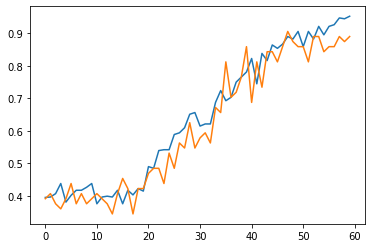

In [25]:
plt.plot(historyModel.history["accuracy"])
plt.plot(historyModel.history["val_accuracy"])

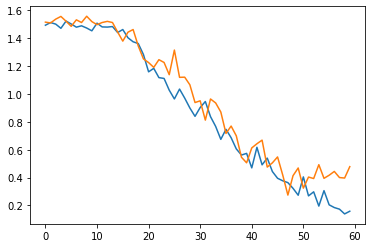

In [26]:
plt.plot(historyModel.history["loss"])
plt.plot(historyModel.history["val_loss"])

In [27]:
model = tf.keras.models.load_model("faces.h5")

In [28]:
cropAllImages(TESTING_CLASSES_PATH, (175, 175))

In [29]:
imagesFileNamesList = [image for image in os.listdir("./") if image.endswith(".jpg")]

In [32]:
for imageFileName in imagesFileNamesList:
    image = tf.keras.preprocessing.image.load_img(imageFileName,
                                                  target_size=(175, 175))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.

    plt.imshow(image)

    index = np.argmax(model.predict(image[tf.newaxis, ...]))

    print(classes[index])

    plt.show()

In [33]:
# STAMPA LE CLASSI DEL MODELLO
classes

{0: 'Adam Sandler',
 1: 'Adele',
 2: 'Andy Samberg',
 3: 'Arnold Schwarzenegger',
 4: 'Ben Stiller'}